# Homework 2 - Reinforcement Learning
Yifan WANG

In [1]:
import numpy as np
import arms
import matplotlib.pyplot as plt
from linearmab_models import ToyLinearModel, ColdStartMovieLensModel
import threading

# 1. Stochastic Multi-Armed Bandits on Simulated Data
## 1.1 Bernoulli bandit models

### Function implementations


In [2]:
def UCB1(T, mab, rho=0.1):
    k = len(mab)
    N = np.zeros(k)
    S = np.zeros(k)
    rew = np.zeros(T)
    draws = np.zeros(T, dtype=np.int32)
    
    # initialization
    for i in range(k):
        r = mab[i].sample()
        N[i] += 1
        S[i] += r
        rew[i] = r
        draws[i] = i
    for i in range(k, T):
        a = np.argmax(S/N + rho * np.sqrt(np.log(i)/(2*N)))
        r = mab[a].sample()
        N[a] += 1
        S[a] += r
        rew[i] = r
        draws[i] = a
    return rew, draws

def TS(T, mab, rho=0.1):
    k = len(mab)
    N = np.zeros(k)
    S = np.zeros(k)
    rew = np.zeros(T)
    draws = np.zeros(T, dtype=np.int32)
    
    for i in range(T):
        p = np.random.beta(S+1, N-S+1)
        a = np.argmax(p)
        r = mab[a].sample()
        N[a] += 1
        S[a] += r
        rew[i] = r
        draws[i] = a
    return rew, draws   

def baseline(T, mab):
    k = len(mab)
    N = np.zeros(k)
    S = np.zeros(k)
    rew = np.zeros(T)
    draws = np.zeros(T, dtype=np.int32)
    
    # initialization
    for i in range(k):
        r = mab[i].sample()
        N[i] += 1
        S[i] += r
        rew[i] = r
        draws[i] = i
    
    for i in range(k, T):
        a = np.argmax(S/N)
        r = mab[a].sample()
        N[a] += 1
        S[a] += r
        rew[i] = r
        draws[i] = a
    return rew, draws 

def kl(x, y):
    return x*np.log(x/y) + (1-x)*np.log((1-x)/(1-y))

def Cp(P):
    pmax = np.max(P)
    v = 0
    for pa in P:
        if pa < pmax:
            v += (pmax-pa)/(kl(pa, pmax))
    return v

### Question 1
#### First Bernoulli bandit problem

In [6]:
# Build your own bandit problem
random_state = np.random.randint(1, 312414)

# this is an example, please change the parameters or arms!
arm1 = arms.ArmBernoulli(0.80, random_state=random_state)
arm2 = arms.ArmBernoulli(0.60, random_state=random_state)
arm3 = arms.ArmBernoulli(0.40, random_state=random_state)
arm4 = arms.ArmBernoulli(0.20, random_state=random_state)

MAB = [arm1, arm2, arm3, arm4]

# bandit : set of arms
nb_arms = len(MAB)
means = [el.mean for el in MAB]

# Display the means of your bandit (to find the best)
print('means: {}'.format(means))
mu_max = np.max(means)
cp = Cp(means)
print("Cp", cp)

means: [0.8, 0.6, 0.4, 0.2]
Cp 3.6798579379


#### One simulations

Cp 3.6798579379


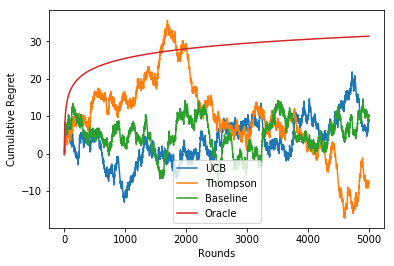

In [7]:
# Comparison of the regret on one run of the bandit algorithm
# try to run this multiple times, you should observe different results

T = 5000  # horizon

rew1, draws1 = UCB1(T, MAB)
reg1 = mu_max * np.arange(1, T + 1) - np.cumsum(rew1)
rew2, draws2 = TS(T, MAB)
reg2 = mu_max * np.arange(1, T + 1) - np.cumsum(rew2)

rew3, _ = baseline(T, MAB)
reg3 = mu_max * np.arange(1, T + 1) - np.cumsum(rew3)

# add oracle t -> C(p)log(t)
print("Cp", cp)
plt.figure(1)
x = np.arange(1, T+1)
plt.plot(x, reg1, label='UCB')
plt.plot(x, reg2, label='Thompson')
plt.plot(x, reg3, label='Baseline')
plt.plot(x, cp*np.log(x), label='Oracle')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.show()

#### (Expected) regret curve for UCB and Thompson Sampling
We also implement a simple baseline method which takes each arm once as initialization and then always takes the arm with maximal average reward.

Cp 3.6798579379


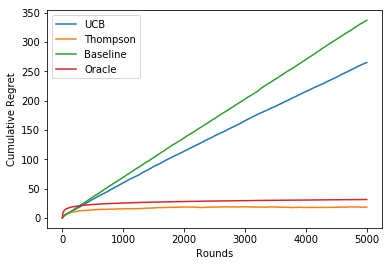

In [8]:
# (Expected) regret curve for UCB and Thompson Sampling
T = 5000  # horizon
N = 200  # number of simulations
reg1 = []
reg2 = []
reg3 = []
for i in range(N):
    rew1, draws1 = UCB1(T, MAB)
    reg1.append(mu_max * np.arange(1, T + 1) - np.cumsum(rew1))
    rew2, draws2 = TS(T, MAB)
    reg2.append(mu_max * np.arange(1, T + 1) - np.cumsum(rew2))
    rew3, _ = baseline(T, MAB)
    reg3.append(mu_max * np.arange(1, T + 1) - np.cumsum(rew3))

print("Cp", cp)
plt.figure(1)
x = np.arange(1, T+1)
plt.plot(x, np.mean(reg1, 0), label='UCB')
plt.plot(x, np.mean(reg2, 0), label='Thompson')
plt.plot(x, np.mean(reg3, 0), label='Baseline')
plt.plot(x, cp*np.log(x), label='Oracle')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.show()

#### Second Bernoulli bandit problem

Cp 14.6405747204
means: [0.1, 0.1, 0.15, 0.2, 0.25]


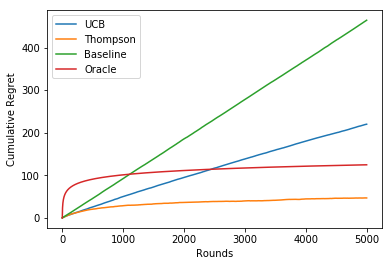

In [11]:
# Another bandit problem
random_state = np.random.randint(1, 312414)

# this is an example, please change the parameters or arms!
arm1 = arms.ArmBernoulli(0.1, random_state=random_state)
arm2 = arms.ArmBernoulli(0.10, random_state=random_state)
arm3 = arms.ArmBernoulli(0.15, random_state=random_state)
arm4 = arms.ArmBernoulli(0.20, random_state=random_state)
arm5 = arms.ArmBernoulli(0.25, random_state=random_state)

MAB = [arm1, arm2, arm3, arm4, arm5]

# bandit : set of arms
nb_arms = len(MAB)
means = [el.mean for el in MAB]
cp = Cp(means)
print("Cp", cp)

# Display the means of your bandit (to find the best)
print('means: {}'.format(means))
mu_max = np.max(means)
# (Expected) regret curve for UCB and Thompson Sampling
T = 5000  # horizon
N = 200  # number of simulations
reg1 = []
reg2 = []
reg3 = []
for i in range(N):
    rew1, draws1 = UCB1(T, MAB)
    reg1.append(mu_max * np.arange(1, T + 1) - np.cumsum(rew1))
    rew2, draws2 = TS(T, MAB)
    reg2.append(mu_max * np.arange(1, T + 1) - np.cumsum(rew2))
    rew3, _ = baseline(T, MAB)
    reg3.append(mu_max * np.arange(1, T + 1) - np.cumsum(rew3))


plt.figure(1)
x = np.arange(1, T+1)
plt.plot(x, np.mean(reg1, 0), label='UCB')
plt.plot(x, np.mean(reg2, 0), label='Thompson')
plt.plot(x, np.mean(reg3, 0), label='Baseline')
plt.plot(x, cp*np.log(x), label='Oracle')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.show()

#### Compare the regret of Thompson Sampling with that of UCB1 for two diﬀerent Bernoulli bandit problems with diﬀerent complexity

The first bandit problem has a complexity of 3.68, while the second one has a complexity of 14.64. We notice a remarkable difference that the UCB-1 method has a closer performance to our naive baseline (which means it works relatively worse) in the first problem than the second.

For a Bernoulli bandit problem, when the parameters of Bernoulli distribution are closer to each other, we tend to have a larger complexity, and it might be more difficult for an algorithm to find out the best arm. The Thompson sampling algorithm is les sensitive to complexity and performs quite well for the both cases, while UCB-1 algorithm is more sensitive to complexity.

In [27]:
means = [0.4, 0.5, 0.6, 0.7]
cp = Cp(means)
print("Cp", cp)

Cp 8.28457265393


## 1.2 Non-parametric bandits (bounded rewards)
### Question 2
We have a MAB with dfferent classes of arms: two Bernoulli arms with $p=0.25$ and $p=0.75$, two Beta arms with $(a=1,b=3)$ and $(a=5, b=1)$, and a finite support arm with $p(0)=0.3, p(0.2)=0.1, p(0.5）=0.2, p(0.8)=0.4$.

We propose to use the method in [Agrawal and Goyal, 2012]. To deal with the problem that the reward is not binary (but bounded in [0,1]), each turn we first sample a reward $\tilde r$ from the selected arm, then we perform a Bernoulli trial with success probability $\tilde r$ for the final reward $r$. With probability $\tilde r$, $r=1$ and with probability $1-\tilde r$, $r=0$.

In the case of non-parametric bandits, the notion of complexity still make sense, it is shown in [Burnetas, Katehakis, 1996] that under appropriate assumptions, we can still find a similar lower bound.

In [3]:
def TS2(T, mab, rho=0.1):
    k = len(mab)
    N = np.zeros(k)
    S = np.zeros(k)
    rew = np.zeros(T)
    draws = np.zeros(T, dtype=np.int32)
    
    for i in range(T):
        p = np.random.beta(S+1, N-S+1)
        a = np.argmax(p)
        r = mab[a].sample()
        # Bernoulli trial
        r = 0 if np.random.rand() > r else 1
        N[a] += 1
        S[a] += r
        rew[i] = r
        draws[i] = a
    return rew, draws   


Cp 4.61026786925
means: [0.65, 0.46675521828026356, 0.25, 0.8333333333333334, 0.44000000000000006]


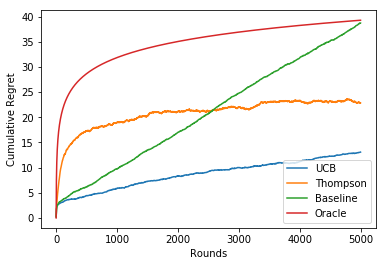

In [10]:
# Another bandit problem
random_state = np.random.randint(1, 312414)

arm1 = arms.ArmBernoulli(0.65, random_state=random_state)
arm2 = arms.ArmExp(0.4, random_state=random_state)
arm3 = arms.ArmBeta(1, 3, random_state=random_state)
arm4 = arms.ArmBeta(5, 1, random_state=random_state)
arm5 = arms.ArmFinite(X=np.asarray([0, 0.2, 0.5, 0.8]), P=np.asarray([0.3, 0.1, 0.2, 0.4]), random_state=random_state)

MAB = [arm1, arm2, arm3, arm4, arm5]

# bandit : set of arms
nb_arms = len(MAB)
means = [el.mean for el in MAB]
cp = Cp(means)
print("Cp", cp)

# Display the means of your bandit (to find the best)
print('means: {}'.format(means))
mu_max = np.max(means)
# (Expected) regret curve for UCB and Thompson Sampling
T = 5000  # horizon
N = 200  # number of simulations
reg1 = []
reg2 = []
reg3 = []
for i in range(N):
    rew1, draws1 = UCB1(T, MAB)
    reg1.append(mu_max * np.arange(1, T + 1) - np.cumsum(rew1))
    rew2, draws2 = TS2(T, MAB)
    reg2.append(mu_max * np.arange(1, T + 1) - np.cumsum(rew2))
    rew3, _ = baseline(T, MAB)
    reg3.append(mu_max * np.arange(1, T + 1) - np.cumsum(rew3))


plt.figure(1)
x = np.arange(1, T+1)
plt.plot(x, np.mean(reg1, 0), label='UCB')
plt.plot(x, np.mean(reg2, 0), label='Thompson')
plt.plot(x, np.mean(reg3, 0), label='Baseline')
plt.plot(x, cp*np.log(x), label='Oracle')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.show()

# 2. Linear Bandit on Real Data

#### Implementation of LinUCB, random basline and $\epsilon$-greedy algorithm.

In [20]:
def LinUCB(T, model, alpha, lam):
    d = model.n_features
    n_a = model.n_actions
    
    A = lam * np.eye(d)
    b = np.zeros((d, 1))
    rew = np.zeros(T)
    draws = np.zeros(T)
    diff_theta = np.zeros(T)
    for i in range(T):
        ub = []
        theta = np.linalg.inv(A).dot(b)
        for a in range(n_a):
            phi = model.features[a].reshape(-1, 1)
            beta = alpha * np.sqrt(phi.T.dot(np.linalg.inv(A)).dot(phi))
            ub.append(phi.T.dot(theta) + beta)
        arm = np.argmax(ub)
        r = model.reward(arm)
        rew[i] = r
        draws[i] = arm
        phi = model.features[arm].reshape(-1, 1)
        A += phi.dot(phi.T)
        b += r * phi
        diff_theta[i] = np.linalg.norm(np.linalg.inv(A).dot(b)-model.real_theta.reshape(-1,1), 2)
    return rew, draws, diff_theta

def random(T, model, lam):
    n_a = model.n_actions
    d = model.n_features
    A = lam * np.eye(d)
    b = np.zeros((d, 1))
    rew = np.zeros(T)
    draws = np.zeros(T)
    diff_theta = np.zeros(T)
    for i in range(T):
        arm = np.random.choice(n_a)
        r = model.reward(arm)
        rew[i] = r
        draws[i] = arm
        phi = model.features[arm].reshape(-1, 1)
        A += phi.dot(phi.T)
        b += r * phi
        diff_theta[i] = np.linalg.norm(np.linalg.inv(A).dot(b)-model.real_theta.reshape(-1,1), 2)
    return rew, draws, diff_theta

def greedy(T, model, eps, alpha, lam):
    d = model.n_features
    n_a = model.n_actions
    
    A = lam * np.eye(d)
    b = np.zeros((d, 1))
    rew = np.zeros(T)
    draws = np.zeros(T)
    diff_theta = np.zeros(T)
    for i in range(T):
        ub = []
        theta = np.linalg.inv(A).dot(b)
        for a in range(n_a):
            phi = model.features[a].reshape(-1, 1)
            ub.append(phi.T.dot(theta))
        if np.random.rand() > eps:
            arm = np.argmax(ub)
        else:
            arm = np.random.choice(n_a)
        r = model.reward(arm)
        rew[i] = r
        draws[i] = arm
        phi = model.features[arm].reshape(-1, 1)
        A += phi.dot(phi.T)
        b += r * phi
        diff_theta[i] = np.linalg.norm(np.linalg.inv(A).dot(b)-model.real_theta.reshape(-1,1), 2)
    return rew, draws, diff_theta

In [4]:
random_state = np.random.randint(1, 312414)
model = ColdStartMovieLensModel(
    random_state=random_state,
    noise=0.1
)
mu_max = model.best_arm_reward()
print("max reward", mu_max)
D = model.features.dot(model.real_theta)
print("Best arm", np.argmax(D))

max reward 19.6455968703
Best arm 41


## Tuning
To be able to fairly compare the three methods, we first try to tune their hyper-parameters. Since a horizon $T=6000$ takes a long time, and we observe that the algorithms usually converge before $t=100$, we firstly change hyper parameters and observe results with $T=100$. To make it even faster, we use multithreading to speed up.

#### Tune $\alpha$

In [219]:
N = 20
T = 200
reg1 = np.zeros((N, T))
reg2 = np.zeros((N, T))
reg3 = np.zeros((N, T))
diff_theta1 = np.zeros((N, T))
diff_theta2 = np.zeros((N, T))
diff_theta3 = np.zeros((N, T))

class MyThread(threading.Thread):
    def __init__(self, i):
        self.i = i
        threading.Thread.__init__(self)
        
    def run(self):
        global reg1, reg2, reg3, diff_theta1, diff_theta2, diff_theta3
        i = self.i
        rew1, draws1, d1 = LinUCB(T, model, alpha=1, lam=0.1)
        reg1[i] = mu_max * np.arange(1, T + 1) - np.cumsum(rew1)
        rew2, draws2, d2 = LinUCB(T, model, alpha=2., lam=0.1)
        reg2[i] = mu_max * np.arange(1, T + 1) - np.cumsum(rew2)
        rew3, draws3, d3 = LinUCB(T, model, alpha=3., lam=0.1)
        reg3[i] = mu_max * np.arange(1, T + 1) - np.cumsum(rew3)
        diff_theta1[i] = d1
        diff_theta2[i] = d2
        diff_theta3[i] = d3
threads = [MyThread(i) for i in range(N)]

for t in threads:
    t.start()
for t in threads:
    t.join()

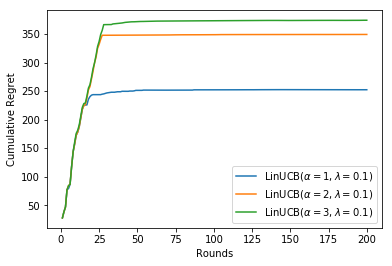

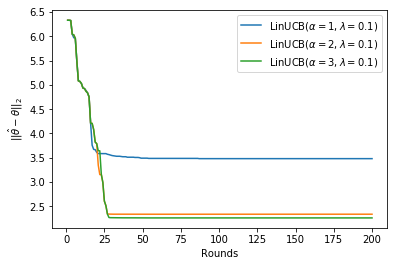

In [220]:
plt.figure(1)
x = np.arange(1, T+1)
plt.plot(x, np.mean(reg1, 0), label=r'LinUCB($\alpha=1, \lambda=0.1$)')
plt.plot(x, np.mean(reg2, 0), label=r'LinUCB($\alpha=2, \lambda=0.1$)')
plt.plot(x, np.mean(reg3, 0), label=r'LinUCB($\alpha=3, \lambda=0.1$)')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.show()

plt.figure(2)
x = np.arange(1, T+1)
plt.plot(x, np.mean(diff_theta1, 0), label=r'LinUCB($\alpha=1, \lambda=0.1$)')
plt.plot(x, np.mean(diff_theta2, 0), label=r'LinUCB($\alpha=2, \lambda=0.1$)')
plt.plot(x, np.mean(diff_theta3, 0), label=r'LinUCB($\alpha=3, \lambda=0.1$)')
plt.xlabel('Rounds')
plt.ylabel(r'$||\hat \theta - \theta||_2$')
plt.legend()
plt.show()

For LinUCB, we observe that a larger $\alpha$ let the algorithm explore more, and can have a better approximation of the true $\theta$, but will bring us more cumulative regret. 

#### Tune $\lambda$

In [29]:
N = 20
T = 200
reg1 = np.zeros((N, T))
reg2 = np.zeros((N, T))
reg3 = np.zeros((N, T))
diff_theta1 = np.zeros((N, T))
diff_theta2 = np.zeros((N, T))
diff_theta3 = np.zeros((N, T))

class MyThread(threading.Thread):
    def __init__(self, i):
        self.i = i
        threading.Thread.__init__(self)
        
    def run(self):
        global reg1, reg2, reg3, diff_theta1, diff_theta2, diff_theta3
        i = self.i
        rew1, draws1, d1 = LinUCB(T, model, alpha=1, lam=0.01)
        reg1[i] = mu_max * np.arange(1, T + 1) - np.cumsum(rew1)
        rew2, draws2, d2 = LinUCB(T, model, alpha=1., lam=0.05)
        reg2[i] = mu_max * np.arange(1, T + 1) - np.cumsum(rew2)
        rew3, draws3, d3 = LinUCB(T, model, alpha=1., lam=0.1)
        reg3[i] = mu_max * np.arange(1, T + 1) - np.cumsum(rew3)
        diff_theta1[i] = d1
        diff_theta2[i] = d2
        diff_theta3[i] = d3
threads = [MyThread(i) for i in range(N)]

for t in threads:
    t.start()
for t in threads:
    t.join()

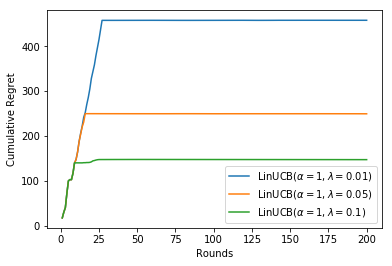

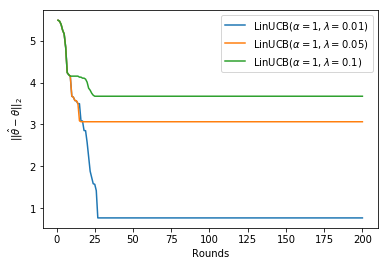

In [30]:
plt.figure(1)
x = np.arange(1, T+1)
plt.plot(x, np.mean(reg1, 0), label=r'LinUCB($\alpha=1, \lambda=0.01$)')
plt.plot(x, np.mean(reg2, 0), label=r'LinUCB($\alpha=1, \lambda=0.05$)')
plt.plot(x, np.mean(reg3, 0), label=r'LinUCB($\alpha=1, \lambda=0.1$)')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.show()

plt.figure(2)
x = np.arange(1, T+1)
plt.plot(x, np.mean(diff_theta1, 0), label=r'LinUCB($\alpha=1, \lambda=0.01$)')
plt.plot(x, np.mean(diff_theta2, 0), label=r'LinUCB($\alpha=1, \lambda=0.05$)')
plt.plot(x, np.mean(diff_theta3, 0), label=r'LinUCB($\alpha=1, \lambda=0.1$)')
plt.xlabel('Rounds')
plt.ylabel(r'$||\hat \theta - \theta||_2$')
plt.legend()
plt.show()

For LinUCB, a larger $\lambda$ introduces a bias in the estimation, but can make the estimation more robust and reduce the cumulative regret. However, a too large $\lambda$ will lead to a bad estimation of $\theta$, and thus a great regret.

#### Comparaison
As for $\epsilon$-greedy method and random baseline, we choose the setting with lowest cumulative regret we observe for LinUCB ($\lambda=0.1, \alpha=1$), and tune a little $\epsilon$

In [26]:
N = 20
T = 200
reg1 = np.zeros((N, T))
reg2 = np.zeros((N, T))
reg3 = np.zeros((N, T))
reg4 = np.zeros((N, T))
diff_theta1 = np.zeros((N, T))
diff_theta2 = np.zeros((N, T))
diff_theta3 = np.zeros((N, T))
diff_theta4 = np.zeros((N, T))

class MyThread(threading.Thread):
    def __init__(self, i):
        self.i = i
        threading.Thread.__init__(self)
        
    def run(self):
        global reg1, reg2, reg3
        i = self.i
        rew1, draws1, d1 = LinUCB(T, model, alpha=1., lam=0.1)
        reg1[i] = mu_max * np.arange(1, T + 1) - np.cumsum(rew1)
        rew2, draws2, d2 = random(T, model, lam=1.)
        reg2[i] = mu_max * np.arange(1, T + 1) - np.cumsum(rew2)
        rew3, draws3, d3 = greedy(T, model, eps=0.1, alpha=1., lam=0.1)
        reg3[i] = mu_max * np.arange(1, T + 1) - np.cumsum(rew3)
        rew4, draws4, d4 = greedy(T, model, eps=0.3, alpha=1., lam=0.1)
        reg4[i] = mu_max * np.arange(1, T + 1) - np.cumsum(rew4)
        diff_theta1[i] = d1
        diff_theta2[i] = d2
        diff_theta3[i] = d3
        diff_theta4[i] = d4

threads = [MyThread(i) for i in range(N)]

for t in threads:
    t.start()
for t in threads:
    t.join()

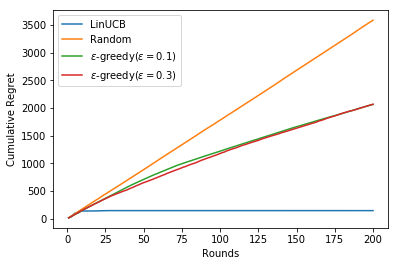

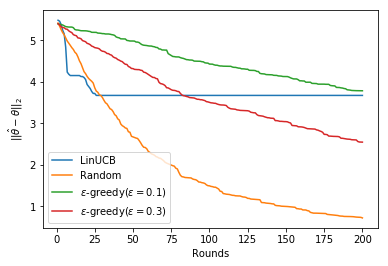

In [27]:
plt.figure(1)
x = np.arange(1, T+1)
plt.plot(x, np.mean(reg1, 0), label=r'LinUCB')
plt.plot(x, np.mean(reg2, 0), label=r'Random')
plt.plot(x, np.mean(reg3, 0), label=r'$\epsilon$-greedy($\epsilon=0.1$)')
plt.plot(x, np.mean(reg4, 0), label=r'$\epsilon$-greedy($\epsilon=0.3$)')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.show()

plt.figure(2)
x = np.arange(1, T+1)
plt.plot(x, np.mean(diff_theta1, 0), label=r'LinUCB')
plt.plot(x, np.mean(diff_theta2, 0), label=r'Random')
plt.plot(x, np.mean(diff_theta3, 0), label=r'$\epsilon$-greedy($\epsilon=0.1$)')
plt.plot(x, np.mean(diff_theta4, 0), label=r'$\epsilon$-greedy($\epsilon=0.3$)')
plt.xlabel('Rounds')
plt.ylabel(r'$||\hat \theta - \theta||_2$')
plt.legend()
plt.show()

We firstly compare the different methods with $T=200$, which takes less time. The $\epsilon$-greedy methods and the random baseline can achieve a better estimation of $\theta$ than LinUCB, but have a large cumulative regret that increases all the time. This is because these methods will continue exploring even they already find the best arm, which gives us more different samples to better estimate but keeps bringing regret.

Finally, we compare the different methods with $T=6000$. We observe that LinUCB can find the best arm quickly, and thus its cumulative regret doesn't increase, while the other two methods keep exploring and making mistakes.

In [32]:
N = 10
T = 6000
reg1 = np.zeros((N, T))
reg2 = np.zeros((N, T))
reg3 = np.zeros((N, T))
diff_theta1 = np.zeros((N, T))
diff_theta2 = np.zeros((N, T))
diff_theta3 = np.zeros((N, T))

class MyThread(threading.Thread):
    def __init__(self, i):
        self.i = i
        threading.Thread.__init__(self)
        
    def run(self):
        global reg1, reg2, reg3
        i = self.i
        rew1, draws1, d1 = LinUCB(T, model, alpha=1., lam=0.1)
        reg1[i] = mu_max * np.arange(1, T + 1) - np.cumsum(rew1)
        rew2, draws2, d2 = random(T, model, lam=1)
        reg2[i] = mu_max * np.arange(1, T + 1) - np.cumsum(rew2)
        rew3, draws3, d3 = greedy(T, model, eps=0.1, alpha=1., lam=0.1)
        reg3[i] = mu_max * np.arange(1, T + 1) - np.cumsum(rew3)
        diff_theta1[i] = d1
        diff_theta2[i] = d2
        diff_theta3[i] = d3

threads = [MyThread(i) for i in range(N)]

for t in threads:
    t.start()
for t in threads:
    t.join()

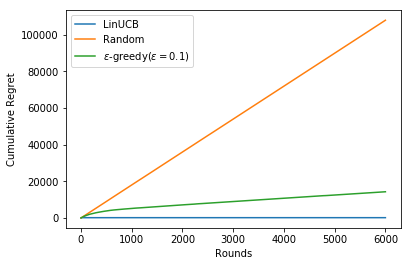

In [33]:
plt.figure(1)
x = np.arange(1, T+1)
plt.plot(x, np.mean(reg1, 0), label=r'LinUCB')
plt.plot(x, np.mean(reg2, 0), label=r'Random')
plt.plot(x, np.mean(reg3, 0), label=r'$\epsilon$-greedy($\epsilon=0.1$)')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.show()